# Reshaping statistical data

In [1]:
import pandas as pd
import geopandas as gpd
import json
import os
import googlemaps
from collections import defaultdict, OrderedDict
from tqdm import tqdm

In [2]:
os.chdir('D:/bachelors/datasets/')

## Read mappers for columns

In [3]:
metadata = pd.read_excel('territory_bases_v2/all_meta_edited.xlsx', sheet_name = None)
del metadata['2019']

mapper_columns = defaultdict(dict)
for yearspan, md_table in metadata.items():
    mapper_columns[yearspan] = metadata[yearspan].dropna(
        subset = ['Key', 'mapped']
    )[['Key', 'mapped']].set_index('Key').to_dict()['mapped']

In [25]:
with open('Variables/mappers/territory_bases_map.json', 'w') as outfile:
    json.dump(mapper_columns, outfile)

In [4]:
with open('Variables/mappers/territory_bases_map.json') as infile:
    mapper_columns = json.load(infile)

## Read, filter and map columns of datatables

In [5]:
databases = defaultdict(dict)
for yearspan, col_renamer in mapper_columns.items():
    base = pd.read_csv(f'territory_bases_v2/database_{yearspan}.csv', sep = ';')
    base = base[base['SoortRegio_2'] == 'Gemeente  ']
    databases[yearspan] = base[list(col_renamer.keys())].rename(columns = col_renamer)

C:\Users\mtopn\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (35,88,93,111) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\mtopn\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (36,37,98,122,142,143,158,159) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Get communes names, geocode, map to 2018 communes

In [5]:
def getCommunes(df):
    """
    Returns the set of unique communes
    """
    return set().union(set(df.geo_commune.dropna()))

In [6]:
with open('Variables/mappers/commune_mapper_stats.json') as infile:
    commune_map = json.load(infile)

In [7]:
communes_set = set()
for dset in databases:
    communes_set = communes_set.union(getCommunes(databases[dset]))
    
communes = pd.DataFrame({'commune' : list(communes_set)}).assign(
    commune = lambda frame: frame.commune.str.strip()
)

In [8]:
communes['commune_renewed'] = pd.Series()
communes.loc[communes.commune.isin(commune_map.keys()), 'commune_renewed'] = communes.loc[communes.commune.isin(commune_map.keys()), 'commune'].map(commune_map)
communes.fillna(method = 'ffill', axis = 1, inplace = True)

In [117]:
communes_geocode = pd.DataFrame(communes.commune_renewed.unique()).rename(columns = {0 : 'commune_ok'}).assign(
    address = lambda frame: frame.commune_ok.apply(lambda x: x + ', Netherlands'),
    lat = pd.Series(),
    lon = pd.Series()
)

In [120]:
gmaps = googlemaps.Client(key= '')

In [121]:
def gcode_gmaps(location):
    try:
        response = gmaps.geocode(location)
        most_relevant = response[0]
        location = most_relevant['geometry']['location']
        
        return location['lat'], location['lng'], response
    except Exception as e:
        print(e)
        return None, None, response

In [122]:
responses = defaultdict(dict)
for i, row in tqdm(communes_geocode.iterrows()):
    location = row['address']
    lat, lon, response = gcode_gmaps(location)
#     sleep(1)
    
    responses[row['commune_ok']] = response
    
    communes_geocode.loc[communes_geocode.address == location, 'lat'] = lat
    communes_geocode.loc[communes_geocode.address == location, 'lon'] = lon
    
with open('communes_responses_google_terra.json', 'w') as outfile:
    json.dump(responses, outfile)

108it [00:05, 13.63it/s]

list index out of range


147it [00:08, 23.93it/s]

list index out of range


282it [00:13, 27.46it/s]

list index out of range


297it [00:14, 23.53it/s]

list index out of range


399it [00:18, 26.56it/s]

list index out of range


411it [00:19, 22.25it/s]

list index out of range


504it [00:23, 21.88it/s]

list index out of range


537it [00:24, 25.48it/s]


In [134]:
communes_geocode.loc[(communes_geocode.lat.isna()) | (communes_geocode.lon.isna())]

,commune_ok,address,lat,lon
110,Harenkarspel,"Harenkarspel, Netherlands",NaN,NaN
147,Wûnseradiel,"Wûnseradiel, Netherlands",NaN,NaN
282,Skarsterlân,"Skarsterlân, Netherlands",NaN,NaN
297,Lemsterland,"Lemsterland, Netherlands",NaN,NaN
401,Ooststelli,"Ooststelli, Netherlands",NaN,NaN
411,Wymbritseradiel,"Wymbritseradiel, Netherlands",NaN,NaN
506,W¹nseradie,"W¹nseradie, Netherlands",NaN,NaN


In [135]:
fix_my_communes = {
    'Wymbritseradiel' : [52.999456, 5.578561],
    'Ooststelli' : [53, 6.3],
    'Lemsterland' : [52.85, 5.716667],
    'Wûnseradiel' : [53.1, 5.466667],
    'W¹nseradie' : [53.1, 5.466667],
    'Skarsterlân' : [52.966667, 5.783333],
    'Harenkarspel' : [52.73, 4.75],
    'Skarsterlân' : [52.966667, 5.783333]
}

In [136]:
communes_geocode.loc[
    communes_geocode.lat.isna(), 'lat'
] = communes_geocode.loc[communes_geocode.lat.isna(), 'commune_ok'].map(fix_my_communes).str[0]

communes_geocode.loc[
    communes_geocode.lon.isna(), 'lon'
] = communes_geocode.loc[communes_geocode.lon.isna(), 'commune_ok'].map(fix_my_communes).str[1]

In [138]:
coordinates_map = {commune : {'lat' : lat, 'lon' : lon} for commune, lat, lon in zip(communes_geocode.commune_ok, communes_geocode.lat, communes_geocode.lon)}

with open('Variables/mappers/coordinates_map_google_geocode_TERRA.json', 'w') as outfile:
    json.dump(coordinates_map, outfile)

In [140]:
from shapely.geometry import Point

In [141]:
geo_points_communes = gpd.GeoDataFrame(communes_geocode, 
                                       crs = {'init' : 'epsg:4326'}, 
                                       geometry = [Point(xy) for xy in zip(communes_geocode.lon, communes_geocode.lat)])

geo_points_communes.to_file('communes_points_google_TERRA.gpkg', driver = 'GPKG')

CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_communes_points_google_TERRA_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_communes_points_google_TERRA_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


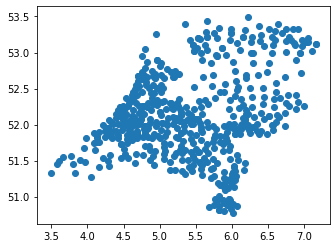

In [13]:
geo_points_communes = gpd.read_file('communes_points_google_TERRA.gpkg')
geo_points_communes.plot()

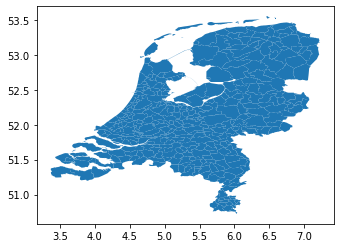

In [14]:
communes_2018 = gpd.read_file('../qgis/base/Netherlands_communes.gpkg')
communes_2018.plot()

In [15]:
joined_communes = gpd.sjoin(communes_2018, geo_points_communes, how = 'left', op = 'intersects')
joined_communes.head()

,NAME,POPULATION,Area,DENSITY,geometry,index_right,commune_ok,address,lat,lon
0,Aa en Hunze,25390,279914646,90.71,(POLYGON ((6.944836772102481 52.99215596570361...,179,Aa en Hunze,"Aa en Hunze, Netherlands",53.010485,6.749528
1,Assen,67708,83621452,809.70,(POLYGON ((6.568604595030538 52.94576501347922...,290,Assen,"Assen, Netherlands",52.992753,6.564228
2,Borger-Odoorn,25351,272907572,92.89,(POLYGON ((7.020432471769706 52.87130845397606...,100,Borger-Odoorn,"Borger-Odoorn, Netherlands",52.889372,6.888404
3,Coevorden,35299,299357668,117.92,(POLYGON ((6.815015728840681 52.64786459842855...,248,Coevorden,"Coevorden, Netherlands",52.661357,6.741062
4,De Wolden,23917,226940619,105.39,(POLYGON ((6.454367764449058 52.78519798884386...,251,De Wolden,"De Wolden, Netherlands",52.681979,6.366039


In [16]:
names_map = dict(zip(joined_communes.commune_ok, joined_communes.NAME))

with open('Variables/mappers/communes_names_map_TERRA.json', 'w') as outfile:
    json.dump(names_map, outfile)

### Map'em all

In [6]:
with open('Variables/mappers/communes_names_map_TERRA.json') as infile:
    names_map = json.load(infile)

In [ ]:
communes = communes.assign(
    commune_2018 = lambda frame: frame.commune_renewed.map(names_map)
)

final_commune_mapper =  dict(zip(communes['commune'], communes['commune_2018']))

In [23]:
with open('Variables/mappers/communes_raw_to_2018_Terra.json', 'w') as outfile:
    json.dump(final_commune_mapper, outfile)

In [8]:
with open('Variables/mappers/communes_raw_to_2018_Terra.json') as infile:
    final_commune_mapper = json.load(infile)

## Statistics aggregation by communes

### Create aggregation functions data

In [9]:
dataframe = defaultdict(dict)
for yearspan, database in databases.items():
    dataframe[yearspan] = list(database)

In [34]:
writer = pd.ExcelWriter('Variables/StatsComputationRules.xlsx')

for yearspan, columns in dataframe.items():
    pd.Series(columns).rename('columns').to_excel(writer, sheet_name = yearspan, index = None)
    
writer.save()

In [10]:
aggregation_rules = pd.read_excel('Variables/StatsComputationRules.xlsx', sheet_name = None)

def get_dict(df):
    return df.dropna().set_index('columns').to_dict()['agg_func']

aggregation_rules_map = {yearspan : get_dict(df) for yearspan, df in aggregation_rules.items()}

In [45]:
with open('Variables/mappers/aggregation_rules.json', 'w') as outfile:
    json.dump(aggregation_rules_map, outfile)

In [11]:
with open('Variables/mappers/aggregation_rules.json') as infile:
    aggregation_rules_map = json.load(infile)

In [12]:
def aggregate(yearspan, database):
    if yearspan in ['2009 - 2012', '2004 - 2008']:
        agg_columns = ['year', 'commune_mapped']
    else:
        agg_columns = ['commune_mapped']
    current_rules = aggregation_rules_map[yearspan]
    db = database.assign(
        commune_mapped = lambda frame: frame.geo_commune.str.strip().map(final_commune_mapper)
    )[
        list(current_rules.keys()) + agg_columns
    ]
    communes = db['commune_mapped'].copy()
    
    db = db.apply(lambda column: pd.to_numeric(column, errors = 'coerce'))
    db['commune_mapped'] = communes
    db = db.groupby(agg_columns).agg(current_rules)
    return db

In [13]:
aggregated_stats = defaultdict(dict)
for yearspan, database in databases.items():
    
#     current_rules = aggregation_rules_map[yearspan]
#     db = database.assign(
#         commune_mapped = lambda frame: frame.geo_commune.str.strip().map(final_commune_mapper)
#     )[
#         list(current_rules.keys()) + ['commune_mapped']
#     ]
#     communes = db['commune_mapped'].copy()
    
#     db = db.apply(lambda column: pd.to_numeric(column, errors = 'coerce'))
#     db['commune_mapped'] = communes
#     db = db.groupby('commune_mapped').agg(current_rules)
    
    db = aggregate(yearspan, database)
    aggregated_stats[yearspan] = db
#     break

In [16]:
writer = pd.ExcelWriter('reshaped_stats.xlsx')

for yearspan, df in aggregated_stats.items():
    df.to_excel(writer, sheet_name = yearspan)
    
writer.save()